In [113]:
using Dates
using JuMP
using CSV
using DataFrames
using LinearAlgebra
using Distributions
using Plots

include("COVIDResourceAllocation.jl")
using .COVIDResourceAllocation

In [2]:
states = ["CT", "DE", "MA", "MD", "ME", "NH", "NJ", "NY", "PA", "RI"]

start_date = Date(2020, 5, 1)
end_date   = Date(2020, 5, 30)

pct_beds_available = 0.25
travel_threshold_hours = 4.0
hospitalized_days = 14;

In [3]:
N = length(states);
T = (end_date - start_date).value + 1;

In [4]:
forecast_admitted = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
);

In [5]:
forecast_initial = forecast(
    states, start_date-Dates.Day(1), start_date-Dates.Day(1),
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
)[:];

In [6]:
forecast_discharged = forecast(
    states, start_date-Dates.Day(hospitalized_days), start_date-Dates.Day(1),
    level=:state,
    source=:ihme,
    forecast_type=:admitted,
    patient_type=:regular,
    bound_type=:mean,
)
forecast_discharged = hcat(forecast_discharged, zeros(Float32, N, T - hospitalized_days));

In [7]:
beds = n_beds(states, bed_type=:all, pct_beds_available=pct_beds_available);
adj = adjacencies(states, level=:state, source=:google, threshold=travel_threshold_hours);

In [8]:
pct_nurses_available = 0.5
patients_per_nurse_covid = 2.5
nurse_hrs_per_week_covid = 36

@show nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7
@show nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid

@show nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid;
forecast_active = forecast(
    states, start_date, end_date,
    level=:state,
    source=:ihme,
    forecast_type=:active,
    patient_type=:regular,
    bound_type=:mean,
);
nurses = n_nurses(states) * Float32(pct_nurses_available);

nurse_hrs_per_day_covid = nurse_hrs_per_week_covid / 7 = 5.142857142857143
nurses_days_per_day_covid = 24 / nurse_hrs_per_day_covid = 4.666666666666666
nurse_days_per_patient_day_covid = nurses_days_per_day_covid / patients_per_nurse_covid = 1.8666666666666665


In [9]:
model = patient_nurse_allocation(
    beds,
    forecast_initial,
    forecast_discharged,
    forecast_admitted,
    nurses,
    adj,
    los=Exponential(100),
    verbose=true
)
sentp = value.(model[:sentnurses])
sentn = value.(model[:sentpatients])
println("termination status: ", termination_status(model))
println("solve time: ", round(solve_time(model), digits=3), "s")
println("objective function value: ", round(objective_value(model), digits=3))

Set parameter Username
Academic license - for non-commercial use only - expires 2025-04-21
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (mac64[arm] - Darwin 23.4.0 23E214)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 9420 rows, 6600 columns and 503820 nonzeros
Model fingerprint: 0x9d9e7b65
Coefficient statistics:
  Matrix range     [7e-01, 2e+00]
  Objective range  [1e+00, 1e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 2e+04]
Presolve removed 7644 rows and 1628 columns
Presolve time: 0.07s
Presolved: 1776 rows, 4972 columns, 401587 nonzeros

Concurrent LP optimizer: primal simplex, dual simplex, and barrier
Showing barrier log only...


Barrier performed 0 iterations in 0.11 seconds (0.19 work units)
Barrier solve interrupted - model solved by another algorithm


Solved with dual simplex
Iteration    Objective       Primal Inf.    Dual Inf.      Time
     259    1.3540977e+05   0.000000e

In [10]:
model

A JuMP Model
Minimization problem with:
Variables: 6600
Objective function type: AffExpr
`AffExpr`-in-`MathOptInterface.EqualTo{Float64}`: 1620 constraints
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 7200 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 600 constraints
`VariableRef`-in-`MathOptInterface.GreaterThan{Float64}`: 600 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: Gurobi
Names registered in the model: active_nurses, active_patients, nurse_demand, obj_dummy_nurses, obj_dummy_patients, patient_overflow, sentnurses, sentpatients

In [11]:
results = PatientAllocationResults.results_all(sentp, beds, forecast_initial, forecast_admitted, forecast_discharged, states, start_date, hospitalized_days);

In [12]:
println("Total overflow: ", results.total_overflow)
println("Average load: ", results.average_load)

Total overflow: 79776.95
Average load: 7.654549


In [13]:
results.summary_table

Row,location,total_sent,total_received,overflow,overall_load,overflow_nosent,overall_load_nosent
,String,Float64,Float64,Float64,Float64,Float32,Float32
1,CT,3398.96,3441.51,31006.8,0.62156,13884.9,0.512099
2,DE,1926.54,2279.04,2369.16,0.459858,0.0,-0.149694
3,MA,2585.5,368.967,0.0,-0.165755,0.0,0.0629188
4,MD,0.0,1373.0,1337.63,0.158309,73.7739,-0.00288614
5,ME,1144.54,654.039,0.0,-0.282541,0.0,-0.0101372
6,NH,967.0,681.621,4.66166,-0.451711,0.0,-0.267712
7,NJ,1105.38,5701.98,1.2869e5,1.14885,49083.8,0.588553
8,NY,3455.53,709.875,4188.12,0.381593,16734.5,0.482961
9,PA,2237.47,940.361,0.0,-0.0792948,0.0,0.0104626


In [14]:
results.sent_matrix_table

Row,state,CT,DE,MA,MD,ME,NH,NJ,NY,PA,RI
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,CT,0.0,620.128,0.0,0.0,14.0794,0.0,2296.5,0.0,0.0,468.25
2,DE,0.0,0.0,0.0,579.903,6.08457,0.0,661.0,155.769,0.0,523.783
3,MA,1235.16,0.0,0.0,138.217,143.375,483.5,0.0,0.0,0.0,585.255
4,MD,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,ME,0.0,0.0,0.0,6.08457,0.0,0.0,981.0,0.0,0.0,157.455
6,NH,0.0,0.0,0.0,0.0,0.0,0.0,967.0,0.0,0.0,0.0
7,NJ,56.5542,14.7664,206.589,0.0,0.0,0.0,0.0,0.0,827.471,0.0
8,NY,2149.8,581.79,72.2126,267.536,0.0,198.121,0.0,0.0,112.89,73.1758
9,PA,0.0,862.956,0.0,103.574,490.5,0.0,155.403,554.106,0.0,70.9308


In [15]:
println("First day:")
filter(row -> row.date == start_date, results.complete_table)

First day:


Row,location,date,sent,received,new_patients,active_patients,active_patients_nosent,capacity,overflow,load,overflow_nosent,load_nosent,sent_to,sent_from
,String,Date,Float64,Float64,Float32,Float64,Float32,Float32,Float64,Float64,Float32,Float32,Any,Any
1,CT,2020-05-01,2296.5,3384.96,373.65,5358.49,1973.54,1840.25,3518.24,2.91183,133.287,1.07243,"[(""NJ"", 2296.5)]","[(""MA"", 1235.16), (""NY"", 2149.8)]"
2,DE,2020-05-01,661.0,371.383,23.0751,541.239,169.856,506.75,34.4889,1.06806,0.0,0.335187,"[(""NJ"", 661.0)]","[(""PA"", 371.383)]"
3,MA,2020-05-01,2303.91,0.0,346.806,1484.71,1484.71,3997.75,0.0,0.371387,0.0,0.371387,"[(""CT"", 1235.16), (""NH"", 483.5), (""RI"", 585.255)]",[]
4,MD,2020-05-01,0.0,0.0,290.597,1772.15,1772.15,2228.75,0.0,0.79513,0.0,0.79513,[],[]
5,ME,2020-05-01,981.0,490.5,8.15217,520.515,30.0153,668.0,0.0,0.779215,0.0,0.0449331,"[(""NJ"", 981.0)]","[(""PA"", 490.5)]"
6,NH,2020-05-01,967.0,483.5,12.7217,589.162,105.662,584.5,4.66166,1.00798,0.0,0.180773,"[(""NJ"", 967.0)]","[(""MA"", 483.5)]"
7,NJ,2020-05-01,0.0,5687.4,1073.99,11150.2,5462.78,4553.25,6596.93,2.44884,909.526,1.19975,[],"[(""CT"", 2296.5), (""DE"", 661.0), (""ME"", 981.0), (""NH"", 967.0), (""PA"", 155.403), (""RI"", 626.5)]"
8,NY,2020-05-01,2149.8,554.106,1716.21,6613.17,6059.07,10406.2,0.0,0.6355,0.0,0.582253,"[(""CT"", 2149.8)]","[(""PA"", 554.106)]"
9,PA,2020-05-01,1571.39,0.0,423.688,2699.62,2699.62,7980.25,0.0,0.338287,0.0,0.338287,"[(""DE"", 371.383), (""ME"", 490.5), (""NJ"", 155.403), (""NY"", 554.106)]",[]


In [30]:
s = "CT"
filter(row -> row.location == s, results.complete_table)

Row,location,date,sent,received,new_patients,active_patients,active_patients_nosent,capacity,overflow,load,overflow_nosent,load_nosent,sent_to,sent_from
,String,Date,Float64,Float64,Float32,Float64,Float32,Float32,Float64,Float64,Float32,Float32,Any,Any
1,CT,2020-05-01,2296.5,3384.96,373.65,5358.49,1973.54,1840.25,3518.24,2.91183,133.287,1.07243,"[(""NJ"", 2296.5)]","[(""MA"", 1235.16), (""NY"", 2149.8)]"
2,CT,2020-05-02,14.0794,0.0,371.087,3160.08,2071.63,1840.25,1319.83,1.7172,231.375,1.12573,"[(""ME"", 14.0794)]",[]
3,CT,2020-05-03,13.2299,0.0,369.828,3250.17,2175.79,1840.25,1409.92,1.76615,335.54,1.18233,"[(""RI"", 13.2299)]",[]
4,CT,2020-05-04,0.0,0.0,367.114,3349.65,2288.5,1840.25,1509.4,1.82021,448.251,1.24358,[],[]
5,CT,2020-05-05,4.82938,0.0,363.083,3464.93,2403.78,1840.25,1624.68,1.88286,563.531,1.30623,"[(""RI"", 4.82938)]",[]
6,CT,2020-05-06,0.0,0.0,355.594,3577.84,2521.52,1840.25,1737.59,1.94421,681.27,1.3702,[],[]
7,CT,2020-05-07,0.0,0.0,347.933,3698.84,2642.52,1840.25,1858.59,2.00997,802.273,1.43596,[],[]
8,CT,2020-05-08,0.0,0.0,341.167,3821.0,2764.69,1840.25,1980.75,2.07635,924.435,1.50234,[],[]
9,CT,2020-05-09,0.0,0.0,333.563,3942.85,2886.53,1840.25,2102.6,2.14256,1046.28,1.56855,[],[]


In [17]:
results.sent_to

Dict{String, Vector{String}} with 10 entries:
  "NH" => ["NJ"]
  "CT" => ["DE", "ME", "NJ", "RI"]
  "RI" => ["DE", "MA", "MD", "NJ"]
  "MA" => ["CT", "MD", "ME", "NH", "RI"]
  "ME" => ["MD", "NJ", "RI"]
  "NY" => ["CT", "DE", "MA", "MD", "NH", "PA", "RI"]
  "NJ" => ["CT", "DE", "MA", "PA"]
  "DE" => ["MD", "ME", "NJ", "NY", "RI"]
  "PA" => ["DE", "MD", "ME", "NJ", "NY", "RI"]
  "MD" => []

In [136]:
function getCum_Overflow(states, results)
    #= 
    
    states: the list of states that were in your network 

    results: the output of the function `results_all`

    plots the NETWROK overflow 

    =#

    time_horizon = filter(row -> row.location == states[1], results.complete_table).date
    df = DataFrame(Date = time_horizon)

    # loop over the states 
    for state in states
        # get the states respective overflow
        state_overflow = filter(row -> row.location == state, results.complete_table).overflow

        # append the states data to the df 
        df[!,Symbol(state)] = state_overflow
    end 
    trans_df = permutedims(df)

    dates = []
    overflow_p_day = []
    for col in names(trans_df)
        push!(dates, trans_df[:, col][1])
        push!(overflow_p_day, sum(trans_df[:,col][2:end]))
    end 
    return minimum(dates):maximum(dates), [convert(Float32, x) for x in overflow_p_day]
end

getCum_Overflow (generic function with 1 method)

In [137]:
dates, overflow_p_day= getCum_Overflow(states, results)

(Date("2020-05-01"):Day(1):Date("2020-05-30"), Float32[10349.961, 8241.849, 8647.558, 9080.035, 9532.107, 9991.786, 10480.409, 10973.862, 11462.43, 11942.48  …  580.0455, 533.9156, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])

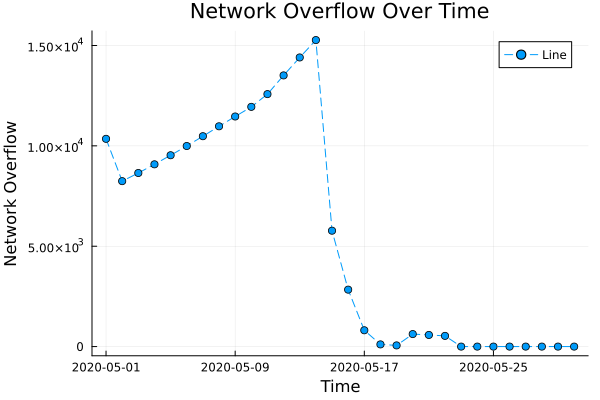

In [141]:
# Create the plot
plot(dates, float(overflow_p_day),
    label="Line",
    linestyle=:dash,
    marker=:circle, 
    xlabel="Time", 
    ylabel="Network Overflow", 
    title="Network Overflow Over Time")  


In [126]:
minimum(dates):maximum(dates)

Date("2020-05-01"):Day(1):Date("2020-05-30")